# Multimodal Contrastive Representation Learning Script

### Suggested Reading

For more background and inspiration, see:  
- **CLIP**: *Learning Transferable Visual Models From Natural Language Supervision* — [arXiv paper](https://arxiv.org/abs/2103.00020)
- **DETiC**: *Detecting Twenty-thousand Classes using Image-level Supervision* — [arXiv paper](https://arxiv.org/abs/2201.02605)

In [1]:
# Initialization and Environment Setup

# Import Necessary Libraries and Custom Modules
# This cell loads all required Python libraries and custom functions from the
# linked lab files. We import everything at the top for clarity.

import os
import torch
import torch.nn.functional as F

# Importing text processing, analysis, and data utilities from previous labs.
# (lab2: text_network, lab6: text prep/analysis, lab7: text/image prep/analysis)
from network_pipeline import process_text_network
from sgns_text_network_embeddings import prepare_visual_genome_text, filter_punctuation_from_network, analyze_embeddings, find_similar_words
from evolutionary_embedding_insertion import load_trained_model, create_mappings, compute_embedding_stats, get_cifar100_vocabulary, analyze_vocabulary_overlap, run_sanity_checks

# Importing all core components for the multimodal training pipeline and
# evaluation from the main script (lab8).
from cifar100_contrastive_alignment import (
    CIFAR100Filtered,
    ImageEncoder,
    filter_dataset_indices,
    create_data_splits,
    create_dataloaders,
    train_with_early_stopping,
    run_epoch,
    collect_embeddings,
    print_analysis_results,
    create_visualizations,
    print_example_retrievals,
    process_ood_images,
    compute_alignment_metrics,
    print_final_report
)

# Determine the Execution Device
# We check for an available NVIDIA GPU (CUDA) for accelerated training.
# If no GPU is found, the code defaults to the CPU.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# The environment is now set up and all required functions are imported.

Using device: cuda


In [2]:
# STAGE 1: Load Corpus & Build Vocabulary from Visual Genome

# This initial stage prepares the text data required for the text-side embeddings.
# We use the Visual Genome (VG) dataset's region descriptions as our text corpus,
# which provides rich, descriptive language for objects and scenes.

print("\n[STAGE 1] Loading Data & Building Vocabulary")
print("-" * 70)

# 1. Define Constants and Check for Text Corpus
# We define the source URL for the VG data, the local file path, and parameters
# for filtering out very rare words and common punctuation during network creation.

TEXT_FILE = 'vg_text.txt'
ZIP_URL = "https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/region_descriptions.json.zip"
RARE_THRESHOLD = 0.00025 # Words appearing less frequently than this threshold are marked as '<RARE>'
PUNCTUATION_TOKENS = {'.', ',', '<RARE>', "'", "!"}

if not os.path.exists(TEXT_FILE):
    print(f"Text file not found. Downloading corpus from {ZIP_URL}...")
    # Calls a helper function to download, unzip, parse the JSON, and save the text descriptions.
    TEXT_FILE = prepare_visual_genome_text(
        zip_url=ZIP_URL,
        zip_path="region_descriptions.json.zip",
        json_path="region_descriptions.json",
        output_path=TEXT_FILE
    )
else:
    print(f"✓ Text file '{TEXT_FILE}' already exists. Skipping download and parsing.")

# 2. 🏗️ Build the Co-occurrence Network (Graph)
# The text file is processed to create a word co-occurrence network. This graph
# forms the basis for learning context-dependent word embeddings (Skip-gram, in spirit).
# The 'inverted' distance mode means closer words have a stronger connection weight.

print("\nProcessing text to build co-occurrence network...")
network_data = process_text_network(
    TEXT_FILE,
    rare_threshold=RARE_THRESHOLD,
    rare_token="<RARE>",
    distance_mode="inverted",
    verbose=True # Prints progress during network construction
)

# 3. Clean the Vocabulary
# Punctuation and the placeholder for rare words are filtered out from the final
# vocabulary since they are not useful for visual-semantic alignment.

network_data = filter_punctuation_from_network(network_data, punctuation_tokens=PUNCTUATION_TOKENS)

# 4. Final Summary
# Extract the final vocabulary (nodes) and report the network statistics.
nodes = network_data['nodes']
vocab_size = len(nodes)

print(f"\n{'-'*70}")
print(f"  STAGE 1 Complete: Vocabulary built.")
print(f"  Total vocabulary size (nodes): {vocab_size} words")
print(f"  Total graph edges (co-occurrences): {network_data['graph'].number_of_edges():,}")


[STAGE 1] Loading Data & Building Vocabulary
----------------------------------------------------------------------
✓ Text file 'vg_text.txt' already exists. Skipping download and parsing.

Processing text to build co-occurrence network...
Loaded text: 154198751 characters
Tokenized: 33662853 tokens
Sample tokens: ['dawg', 'abandoning', 'oung', 'spindles', 'delete', 'griaffe', 'atv', 'perceptible', 'scotland', 'remots', "rabbit's", 'blying', "'nikon'", 'terracota', 'cahirs', 'crunchies', 'workforce', 'giraffis', 'potholder', 'sew']
Replaced 62380 rare tokens (threshold=0.00025)
Final vocabulary: 459 unique tokens
Sample tokens: ['shorts', 'row', 'shadow', 'section', 'to', 'walking', 'sign', 'out', 'very', 'floor', 'keyboard', 'ceiling', 'rack', 'rocks', 'nose', '!', 'leg', 'word', 'head', 'wooden']
Graph: 459 nodes, 50191 edges
Top tokens by frequency:
   1. '.' (freq=6085975)
   2. '<RARE>' (freq=4416304)
   3. 'a' (freq=2220903)
   4. 'the' (freq=2155082)
   5. 'on' (freq=1396037)
 

In [3]:
# STAGE 2: Load Pre-trained Text Model & Compute Embedding Statistics

# This stage loads the text-side embeddings (e.g., Skip-gram or GloVe) that were
# pre-trained on the Visual Genome co-occurrence network from STAGE 1.
# These embeddings represent the semantic meaning of each word in the vocabulary.
# We also compute statistical properties of this embedding space, which are crucial
# for the subsequent genetic algorithm or training initialization.

print("\n[STAGE 2] Loading Model & Analyzing Embedding Space")
print("-" * 70)

# 1. Define Model Configuration and Load Embeddings

MODEL_PATH = 'best_skipgram_523words.pth' # Path to the file containing the pre-trained embedding matrix.
EMBEDDING_DIM = 64               # Dimensionality of the word vectors.
DROPOUT = 0.285                    # Dropout rate used during the original training (if applicable).
VOCAB_SIZE = 523

# The `load_trained_model` function initializes the network and loads the weights.
# It returns the PyTorch model (for potential fine-tuning) and the embedding matrix itself.
model, embeddings = load_trained_model(
    model_path=MODEL_PATH,
    vocab_size=VOCAB_SIZE,         # Use the size determined in STAGE 1
    embedding_dim=EMBEDDING_DIM,
    dropout=DROPOUT
)

# 2. Create Word-Index Mappings
# These mappings are essential for looking up the correct embedding vector
# (by index) for a given word and vice-versa.

checkpoint = torch.load(MODEL_PATH, map_location="cpu") #directly accessing from my trained unwrapped checkpoint to get the nodes (Not using the fresh co-occurence network's nodes from cell 3)
nodes = checkpoint['vocab']
word_to_idx, idx_to_word = create_mappings(nodes)

# 3. Compute Statistical Properties
# Analyzing the embedding space helps set hyper-parameters for optimization.
# Specifically, the global standard deviation is often used to tune the mutation
# rate in evolutionary algorithms or to initialize a new layer's weights.
embedding_stats = compute_embedding_stats(embeddings)

# 4. Final Summary
print(f"\n{'-'*70}")
print(f"✓ STAGE 2 Complete: Model loaded and stats computed.")
print(f"  Embedding matrix shape: {embeddings.shape} (Total words × Dimension)")
print(f"  Key Stats for Fitness Function:")
print(f"    ├─ Mean Vector Norm: {embedding_stats['mean_norm']:.4f} (Average magnitude of vectors)")
print(f"    ├─ Std. Dev of Norms: {embedding_stats['std_norm']:.4f}")
print(f"    └─ Global Std. Dev: {embedding_stats['global_std']:.4f} (Used for controlling search step size)")


[STAGE 2] Loading Model & Analyzing Embedding Space
----------------------------------------------------------------------
Loaded model: 523 embeddings, dim=64

----------------------------------------------------------------------
✓ STAGE 2 Complete: Model loaded and stats computed.
  Embedding matrix shape: (523, 64) (Total words × Dimension)
  Key Stats for Fitness Function:
    ├─ Mean Vector Norm: 1.4432 (Average magnitude of vectors)
    ├─ Std. Dev of Norms: 0.1767
    └─ Global Std. Dev: 0.1795 (Used for controlling search step size)


/tmp/ipykernel_2419/2218109909.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location="cpu") #directly accessing from my train

In [4]:
# STAGE 3: Sanity Checks and Vocabulary Analysis

# This stage performs two essential checks:
# 1. Sanity Checks on the loaded text embeddings to ensure they are semantically sound
#    (e.g., that similar words have high cosine similarity).
# 2. Vocabulary Analysis to determine which classes from the CIFAR-100 dataset
#    have corresponding words in our pre-trained Visual Genome vocabulary.

# 1. Perform Semantic Sanity Checks
# The `run_sanity_checks` function tests the quality of the loaded word embeddings
# by finding the nearest neighbors for a few common words. This confirms that the
# embedding space is semantically meaningful.

run_sanity_checks(model, embeddings, nodes, word_to_idx)

# 2. Vocabulary Analysis & Target Selection
# The goal is to align images (CIFAR-100) with text embeddings (Visual Genome).
# We must ensure that the class names (e.g., 'cat', 'bicycle') exist in our text vocabulary.

print("\nVocabulary Analysis & Target Selection")
print("-" * 70)

# Get the 100 class names from CIFAR-100 dataset.
cifar_vocab = get_cifar100_vocabulary()

# Check for overlap between CIFAR-100 class words and the Visual Genome vocabulary.
# This step identifies which classes we can actually train/test on.
missing_cifar_words = analyze_vocabulary_overlap(cifar_vocab, nodes)

# Report Overlap Statistics
# The list of missing words shows the classes we must exclude from the training process.
# This filtered set of classes will be our final set of "seen" classes for alignment training.

n_train_classes = len(cifar_vocab) - len(missing_cifar_words)

print(f"\nSummary of Vocabulary Overlap:")
print(f"  Total CIFAR-100 Classes: {len(cifar_vocab)}")
print(f"  Classes available in VG vocabulary: {n_train_classes} (i.e., {n_train_classes/len(cifar_vocab)*100:.1f}% coverage)")
print(f"  Missing CIFAR-100 Classes: {len(missing_cifar_words)} (will be excluded from training)")


SANITY CHECKS

1. Model Configuration:
   Training mode: False
   Device: cuda:0

2. Embedding Quality:
   Shape: (523, 64)
   Mean: 0.028770, Std: 0.179450
   Min: -0.680085, Max: 0.832483
   Contains NaN: False, Contains Inf: False

3. Embedding Norms:
   Mean: 1.4432, Std: 0.1767
   Range: [0.2247, 2.1368]

4. Vocabulary Test:
   'man       ' → idx=   9, norm=1.6976
      Similar: woman(0.978), person(0.970), lady(0.920), child(0.915), girl(0.915)
   'woman     ' → idx=  19, norm=1.6983
      Similar: man(0.978), person(0.973), boy(0.941), girl(0.938), lady(0.935)
   'dog       ' → idx=  64, norm=1.4539
      Similar: cat(0.923), horse(0.920), cow(0.914), bear(0.910), fox(0.870)
   'car       ' → idx=  45, norm=1.5658
      Similar: vehicle(0.930), van(0.914), bus(0.901), truck(0.900), motorcycle(0.884)
   'blue      ' → idx=  11, norm=1.4355
      Similar: red(0.900), white(0.873), pink(0.870), purple(0.863), yellow(0.857)

✓ SANITY CHECKS COMPLETE

Vocabulary Analysis & Target Se

In [9]:
# STAGE 4: CLIP-Style Contrastive Learning Setup and Training

# This is the core stage where the visual encoder's projection head is trained
# to align image embeddings (CIFAR-100) with their corresponding text embeddings
# (Visual Genome vocabulary). This process uses the InfoNCE loss, a form of
# contrastive learning analogous to the training used in models like CLIP.

print("\n[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary")
print("-" * 70)

# 1. Define Training Configuration
# The configuration sets crucial hyper-parameters for optimization, loss function,
# and early stopping.

'''TRAIN_CONFIG = {
    'proj_dim': 64,                         # Output dimension of the vision projection head
    'lr': 5e-4,                             # AdamW learning rate
    'weight_decay': 1e-3,                   # L2 regularization
    'temperature': 0.07,                     # Scaling factor for the InfoNCE logits (controls contrast sharpness). Changed from 1.0 to 0.1 to 0.07 (recall increased slightly, cosine similarity reduced sligthly)
    'epochs': 100,                          # Maximum number of epochs
    'patience': 10,                         # Early stopping patience based on validation similarity
    'batch_sizes': {'train': 512, 'eval': 256},
    'save_path': 'best_cifar100_projection_2.pth'
}'''

'''
TRAIN_CONFIG = {
    'proj_dim': 64,
    'lr': 3e-4, #from 5e-4 to 2e-4 to 2e-3
    'weight_decay': 5e-4,
    'temperature': 0.04,   # then also try 0.05 and 0.08 in separate runs
    'epochs': 200,
    'patience': 15,
    #'batch_sizes': {'train': 1024, 'eval': 256},  # bump to 768/1024 if VRAM allows
    'batch_sizes': {'train': 768, 'eval': 256},  # bump to 768/1024 if VRAM allows
    'save_path': 'best_cifar100_projection_5.pth'
}''' #both dropout layers in projection model for best_cifar100_projection_5.pth was p=0.3

TRAIN_CONFIG = {
    'proj_dim': 64,
    'lr': 3e-4, #from 5e-4 to 2e-4 to 2e-3
    'weight_decay': 5e-4,
    'temperature': 0.035,  
    'epochs': 200,
    'patience': 15,
    #'batch_sizes': {'train': 1024, 'eval': 256},  # bump to 768/1024 if VRAM allows
    'batch_sizes': {'train': 768, 'eval': 256},  # bump to 768/1024 if VRAM allows
    'save_path': 'best_cifar100_projection.pth'
} #second dropout layer removed in projection model for best_cifar100_projection_5.pth with one (first) dropout layer (p=0.3)


# 2. Define Target Vocabulary and Embeddings

# Get the subset of CIFAR-100 class words that exist in the pre-trained VG vocabulary.
class_words = [w for w in cifar_vocab if w in word_to_idx]
print(class_words)
print(f"\nOverlapping classes for training: {len(class_words)} / {len(cifar_vocab)}")
print(f"Training classes (first 5): {', '.join(class_words[:5])}...")

# Create label mapping for CIFAR-100 indices to their word and embedding index.
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Extract ALL text embeddings (Full Vocabulary)
# This full set of embeddings will be used later for **zero-shot prediction** on
# the test set, allowing the model to classify images against the entire VG vocabulary.
all_vocab_words = list(word_to_idx.keys())
all_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in all_vocab_words],
    dtype=torch.float32
).to(device)
all_text_emb = F.normalize(all_text_emb, p=2, dim=1) # Normalize embeddings for cosine similarity

# Extract ONLY the Training Class Embeddings (Subset)
# This subset is used *within the batch* for computing the **symmetric InfoNCE loss**
# ($\mathcal{L}_{I \to T} + \mathcal{L}_{T \to I}$).
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

print(f"\nText embedding configuration:")
print(f"  ├─ Full vocabulary embeddings (All VG words): {all_text_emb.shape[0]} words (for OOD analysis)")
print(f"  └─ Training class embeddings: {training_text_emb.shape[0]} classes (for contrastive learning)")

# 3. Data Preparation: Create Splits and DataLoaders
print("\n[Data Split] Creating Train/Val/Test splits...")

# Load the full CIFAR-100 datasets
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")

# Filter indices to include only samples belonging to the overlapping classes
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)

# Split the training data into training and validation sets
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)

print(f"Train samples: {len(train_idx):,} (for training the projection head)")
print(f"Val samples: {len(val_idx):,} (for early stopping)")
print(f"Test samples: {len(test_idx):,} (for final evaluation)")

# Create PyTorch DataLoaders for efficient batch processing
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, TRAIN_CONFIG['batch_sizes'])

# 4. Initialize and Train Model
# The ImageEncoder uses a frozen MobileNetV3 backbone and a trainable projection head.
vision_model = ImageEncoder(proj_dim=TRAIN_CONFIG['proj_dim'], device=device)

# Start training with early stopping based on validation similarity
history, best_epoch, best_val_sim, best_val_loss = train_with_early_stopping(
    vision_model, dataloaders, training_text_emb, class_words,
    label_to_word, TRAIN_CONFIG, device
)

# 5. Final Training Summary
print("\n" + "="*70)
print(" Training Complete!")
print(f"Best model from epoch {best_epoch}")
print(f"Best validation similarity: {best_val_sim:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*70)


[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary
----------------------------------------------------------------------
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', '

train epoch:   0%|          | 0/53 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [15]:
# Load best model for evaluation
print("\n[Loading Best Model for Final Evaluation]")
vision_model = ImageEncoder(proj_dim=TRAIN_CONFIG['proj_dim'], device=device)

if not os.path.exists(TRAIN_CONFIG['save_path']):
    raise FileNotFoundError(f"Model checkpoint not found at {TRAIN_CONFIG['save_path']}. "
                           "Training must complete at least one epoch successfully.")

# Load the saved parameters and move the model to evaluation mode
#checkpoint = torch.load(TRAIN_CONFIG['save_path'])
checkpoint = torch.load('best_cifar100_projection.pth')
vision_model.load_state_dict(checkpoint['model_state_dict'])
vision_model.eval()

# Extract training metadata from checkpoint for reporting
best_epoch = checkpoint['epoch']
best_val_sim = checkpoint['val_similarity']
best_val_loss = checkpoint['val_loss']
history = checkpoint.get('history', None)

print(f"✓ Loaded best model from epoch {best_epoch}")
print(f"  Val Similarity: {best_val_sim:.4f}")


[Loading Best Model for Final Evaluation]
✓ Loaded best model from epoch 102
  Val Similarity: 0.4028


/tmp/ipykernel_2419/1344220490.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_cifar100_projection.pth')


In [16]:
# =============================================================================
# FINAL TEST EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Run an evaluation epoch on the test dataloader. Note: 'training_text_emb'
# contains the embeddings for only the 80 overlapping classes.
test_loss, test_sim = run_epoch(
    vision_model, dataloaders['test'], training_text_emb, class_words,
    label_to_word, None, TRAIN_CONFIG['temperature'], device, 'eval'
)

print(f"\n Test Results:")
print(f"  ├─ Test Loss: {test_loss:.4f} (InfoNCE)")
print(f"  └─ Test Similarity: {test_sim:.4f} (Average Cosine Similarity)")

'''
 Test Results:
  ├─ Test Loss: 2.6117 (InfoNCE)
  └─ Test Similarity: 0.4280 (Average Cosine Similarity)'''


FINAL TEST SET EVALUATION


eval epoch: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s]


📊 Test Results:
  ├─ Test Loss: 2.8011 (InfoNCE)
  └─ Test Similarity: 0.4041 (Average Cosine Similarity)


'\n📊 Test Results:\n  ├─ Test Loss: 2.6117 (InfoNCE)\n  └─ Test Similarity: 0.4280 (Average Cosine Similarity)'

In [17]:
# QUANTITATIVE ANALYSIS (using training classes)
print("\n" + "="*70) #vector of image match to vectors of text
print("QUANTITATIVE ANALYSIS")
print("="*70)

# 1. Collect all visual embeddings from the test set
visual_emb, all_labels = collect_embeddings(vision_model, dataloaders['test'], device)

# 2. Compute all alignment metrics in one pass
class_stats, i2t_recalls, t2i_recalls, sim_matrix = compute_alignment_metrics(
    visual_emb, all_labels, training_text_emb.cpu().numpy(), class_words, label_to_word
)

# 3. Print structured results for easy comparison
print_analysis_results(class_stats, i2t_recalls, t2i_recalls, len(all_labels), len(class_words))


QUANTITATIVE ANALYSIS



Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. orange          | Mean: 0.4914 ± 0.0603
 2. wardrobe        | Mean: 0.4865 ± 0.0799
 3. road            | Mean: 0.4798 ± 0.0774
 4. apple           | Mean: 0.4725 ± 0.0612
 5. motorcycle      | Mean: 0.4640 ± 0.0400
 6. plain           | Mean: 0.4625 ± 0.0709
 7. skyscraper      | Mean: 0.4603 ± 0.0852
 8. chair           | Mean: 0.4598 ± 0.0781
 9. television      | Mean: 0.4565 ± 0.0957
10. castle          | Mean: 0.4516 ± 0.0996

Bottom 10 Worst Aligned Classes:
 1. crocodile       | Mean: 0.3541 ± 0.1136
 2. lizard          | Mean: 0.3515 ± 0.0980
 3. raccoon         | Mean: 0.3472 ± 0.1239
 4. possum          | Mean: 0.3420 ± 0.1355
 5. beaver          | Mean: 0.3419 ± 0.1225
 6. bear            | Mean: 0.3390 ± 0.1006
 7. shrew           | Mean: 0.3372 ± 0.1171
 8. otter           | Mean: 0.3356 ± 0.1169
 9. seal            | Mean: 0.3213 ± 0.12

'\nbest_cifar100_projection_6.pth\n\nTop 10 Best Aligned Classes:\n 1. orange          | Mean: 0.4187 ± 0.0414\n 2. apple           | Mean: 0.4146 ± 0.0590\n 3. wardrobe        | Mean: 0.4145 ± 0.0558\n 4. television      | Mean: 0.3977 ± 0.0773\n 5. road            | Mean: 0.3968 ± 0.0625\n 6. plain           | Mean: 0.3888 ± 0.0541\n 7. sea             | Mean: 0.3851 ± 0.0566\n 8. cloud           | Mean: 0.3840 ± 0.0771\n 9. sunflower       | Mean: 0.3820 ± 0.0512\n10. skyscraper      | Mean: 0.3814 ± 0.0754\n\nBottom 10 Worst Aligned Classes:\n 1. squirrel        | Mean: 0.2977 ± 0.0772\n 2. beaver          | Mean: 0.2920 ± 0.0961\n 3. possum          | Mean: 0.2919 ± 0.1085\n 4. lizard          | Mean: 0.2888 ± 0.0806\n 5. bear            | Mean: 0.2852 ± 0.0861\n 6. raccoon         | Mean: 0.2834 ± 0.0955\n 7. shrew           | Mean: 0.2771 ± 0.0909\n 8. otter           | Mean: 0.2762 ± 0.0939\n 9. seal            | Mean: 0.2598 ± 0.0931\n10. mouse           | Mean: 0.2455 ± 0.102


GENERATING VISUALIZATIONS

Creating confusion matrix...


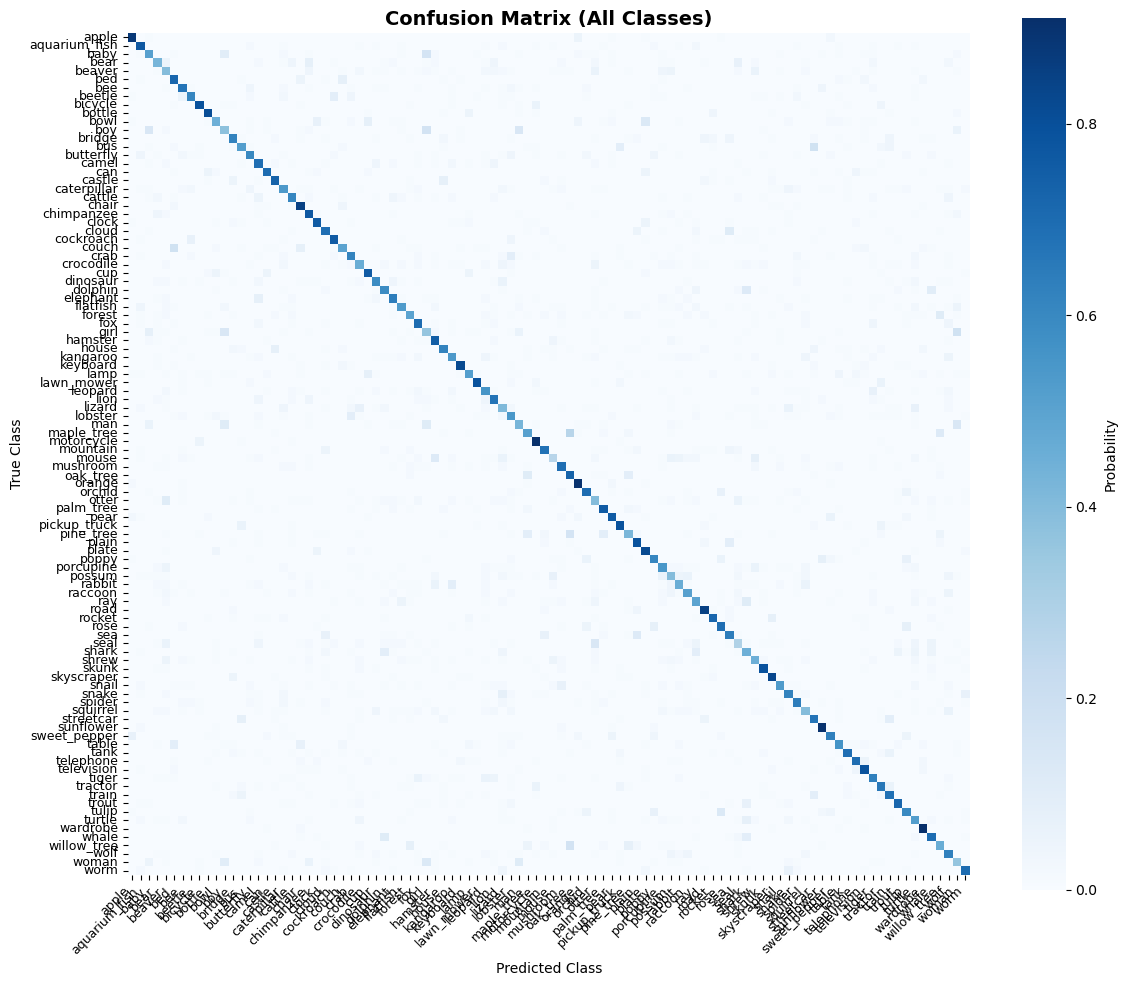


Creating retrieval examples...
Files already downloaded and verified


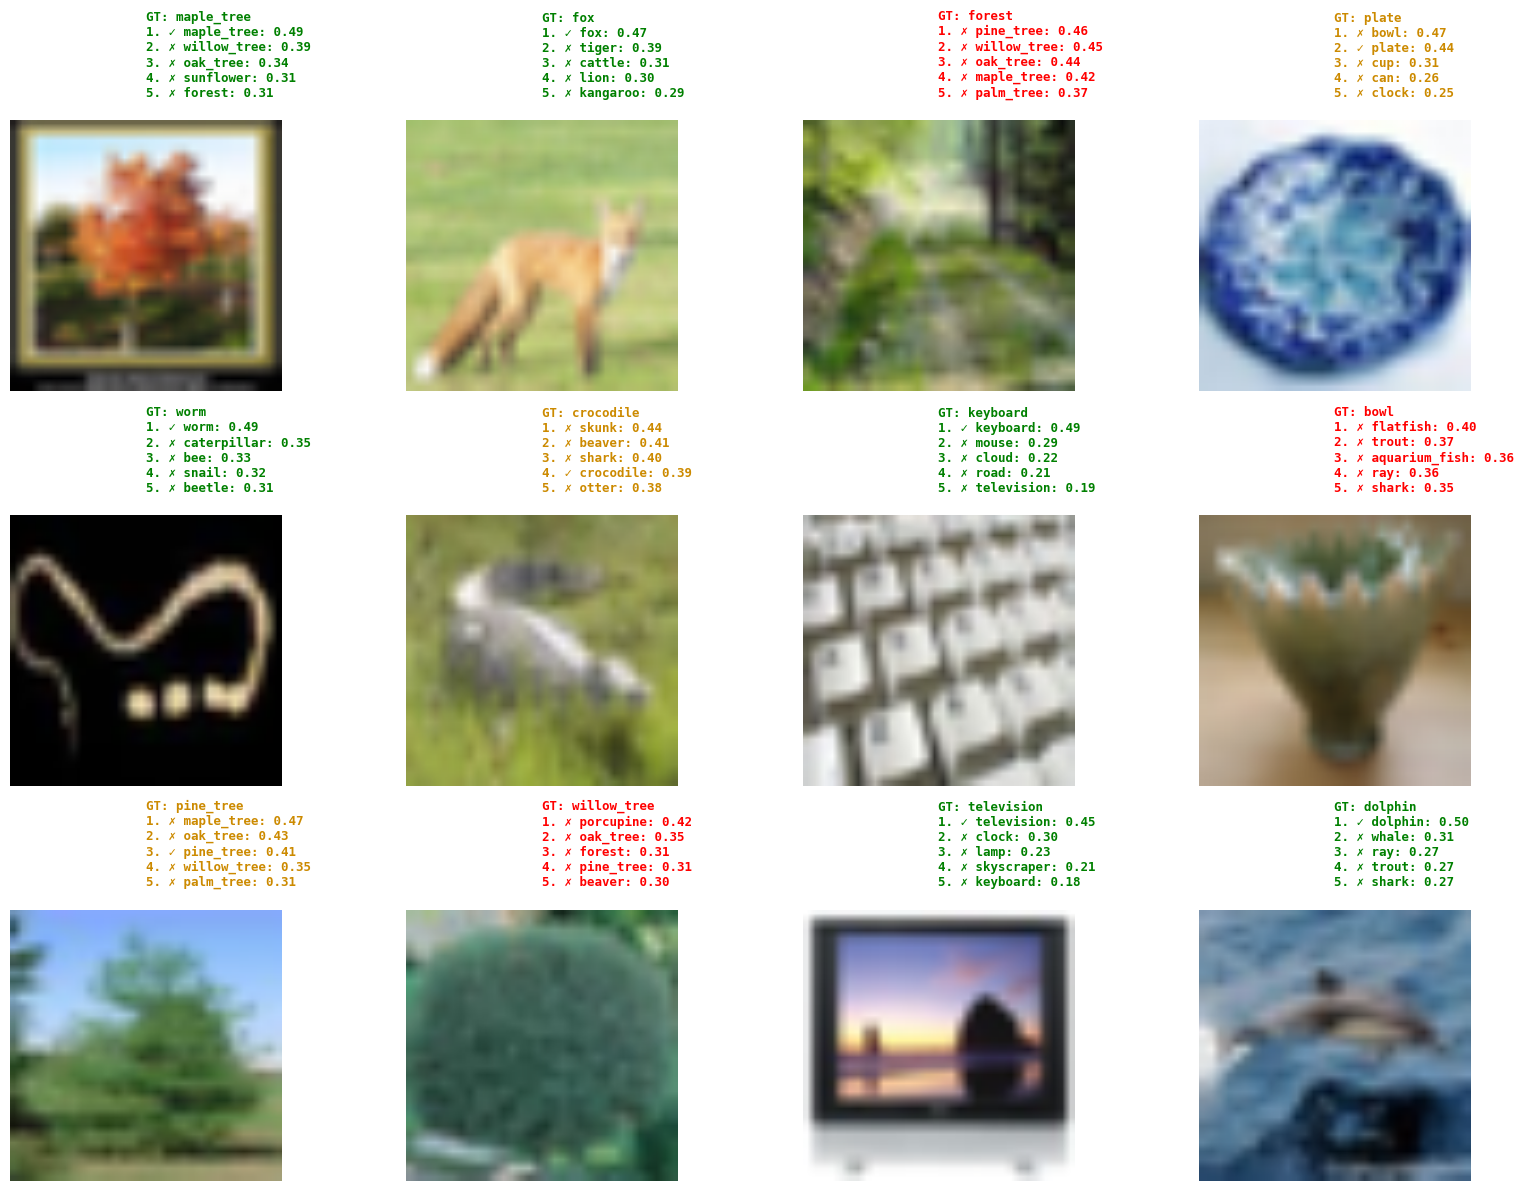


QUALITATIVE EVALUATION

Example Image-to-Text Retrievals:
----------------------------------------------------------------------

Test Image #6463:
  True class: 'bee' (similarity: 0.4348, rank: 1)
  Top 5 predictions:
    1. ✓ bee             (similarity: 0.4348)
    2.   orchid          (similarity: 0.3721)
    3.   butterfly       (similarity: 0.3490)
    4.   spider          (similarity: 0.2836)
    5.   poppy           (similarity: 0.2765)

Test Image #7427:
  True class: 'leopard' (similarity: 0.3499, rank: 2)
  Top 5 predictions:
    1.   crocodile       (similarity: 0.4269)
    2. ✓ leopard         (similarity: 0.3499)
    3.   lizard          (similarity: 0.3283)
    4.   turtle          (similarity: 0.3209)
    5.   snake           (similarity: 0.3198)

Test Image #7849:
  True class: 'crab' (similarity: 0.5370, rank: 1)
  Top 5 predictions:
    1. ✓ crab            (similarity: 0.5370)
    2.   lobster         (similarity: 0.2958)
    3.   plate           (similarity: 0.281

In [18]:
# =============================================================================
# VISUALIZATIONS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Creates and saves confusion matrix and retrieval examples (plots are shown interactively)
create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx)

# =============================================================================
# QUALITATIVE EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUALITATIVE EVALUATION")
print("="*70)

# Prints text-based examples of image-to-text retrieval for a random sample of test images
print_example_retrievals(sim_matrix, all_labels, class_words, label_to_word)


OUT-OF-DISTRIBUTION IMAGE ANALYSIS

🔬 Using FULL vocabulary (523 words) for OOD predictions
   (Training only learned to separate 100 classes)

  ✓ Downloaded: jellyfish
  ✓ Downloaded: goldfish
  ✓ Downloaded: flamingo
  ✓ Downloaded: pizza
  ✓ Downloaded: strawberry
  ✓ Downloaded: hotdog
  ✓ Downloaded: banana
  ✓ Downloaded: parachute
  ✓ Downloaded: school_bus
  ✓ Downloaded: volcano
  ✓ Downloaded: submarine
  ✓ Downloaded: accordion
  ✓ Downloaded: hourglass
  ✓ Downloaded: revolver
  ✓ Downloaded: dome
  ✓ Downloaded: bobsled

🔬 Processing 16 OOD images...

📸 Creating OOD visualization for 16 images...


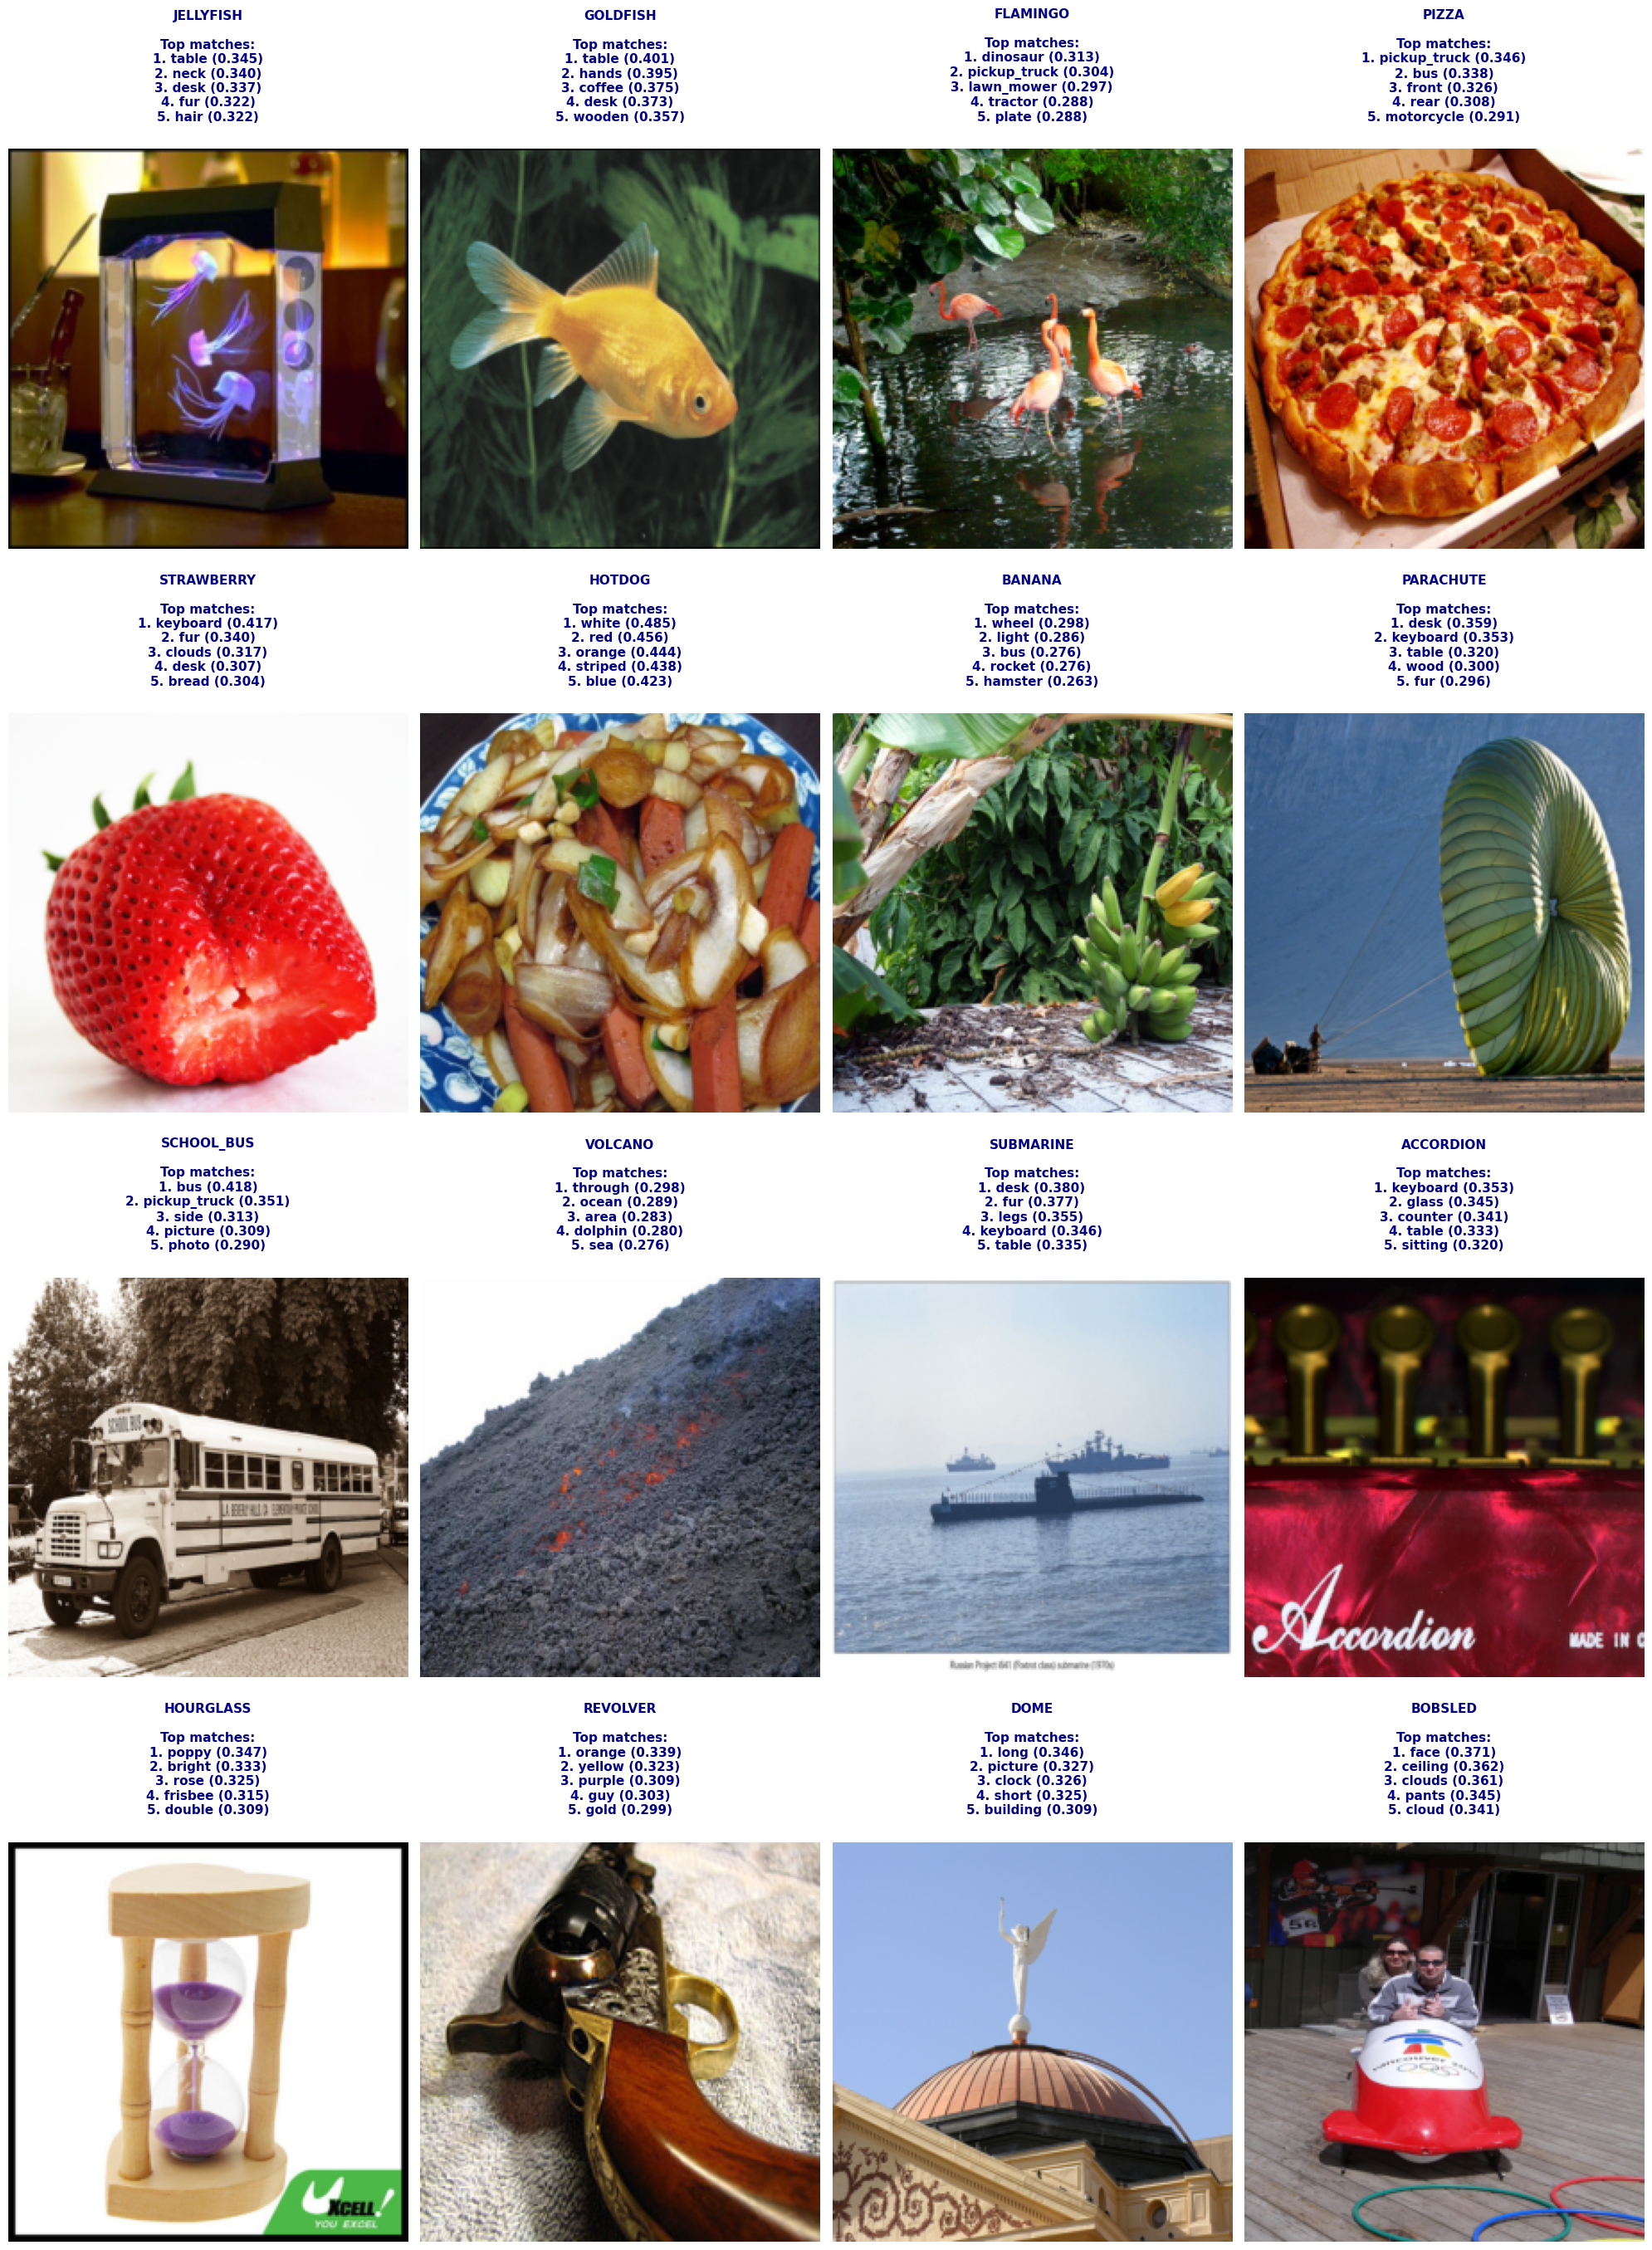

In [15]:
# OOD test images (samples outside of the CIFAR-100 domain)
OOD_URLS = {
    "jellyfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01910747_jellyfish.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "pizza": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07873807_pizza.JPEG",
    "strawberry": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07745940_strawberry.JPEG",
    "hotdog": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07697537_hotdog.JPEG",
    "banana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07753592_banana.JPEG",
    "parachute": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03888257_parachute.JPEG",
    "school_bus": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04146614_school_bus.JPEG",
    "volcano": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n09472597_volcano.JPEG",
    "submarine": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04347754_submarine.JPEG",
    "accordion": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02672831_accordion.JPEG",
    "hourglass": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03544143_hourglass.JPEG",
    "revolver": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04086273_revolver.JPEG",
    "dome": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03220513_dome.JPEG",
    "bobsled": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02860847_bobsled.JPEG",
}

# OOD IMAGE ANALYSIS (using ALL vocabulary words)
print("\n" + "="*70)
print("OUT-OF-DISTRIBUTION IMAGE ANALYSIS")
print("="*70)

print(f"\n Using FULL vocabulary ({len(all_vocab_words):,} words) for OOD predictions")
print(f"   (Training only learned to separate {len(class_words)} classes)")

# This function processes the OOD images and calculates predictions against the full vocabulary.
# all_text_emb was prepared in STAGE 4 and contains embeddings for all {vocab_size} VG words.
ood_images, ood_names, ood_predictions = process_ood_images(
    vision_model, OOD_URLS, all_text_emb.cpu().numpy(), all_vocab_words, device
)

# If any images were successfully downloaded and processed, generate a visualization.
if len(ood_images) > 0:
    # The visualization function is reused, but now receives the OOD data
    # (images, names, predictions) to create a dedicated analysis plot.
    create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx,
                         ood_images, ood_names, ood_predictions)

In [55]:
# =============================================================================
# FINAL REPORT
# =============================================================================
# The final report function gathers all collected metrics and parameters
# (from TRAIN_CONFIG, test results, retrieval metrics, and OOD analysis)
# to print a comprehensive, structured summary.

print_final_report(
    TRAIN_CONFIG, test_loss, test_sim, i2t_recalls, t2i_recalls, class_stats,
    len(train_idx), len(val_idx), len(test_idx), len(class_words),
    TRAIN_CONFIG['batch_sizes']['train'], len(ood_images) > 0,
    history, best_epoch, best_val_sim, best_val_loss, len(all_vocab_words)
    )


📋 Training Configuration:
   ├─ Model: MobileNetV3-Small with projection head
   ├─ Embedding dimension: 64
   ├─ Training samples: 40,000, Validation samples: 10,000, Test samples: 10,000
   ├─ Number of training classes: 100
   ├─ Total vocabulary size: 523 words
   ├─ Total epochs trained: 89, Best epoch: 89
   └─ Early stopping patience: 15 

🎯 Performance Metrics:
   ├─ Best Val Similarity: 0.3808
   ├─ Test Similarity: 0.3820, Test Loss: 2.6307
   ├─ Random baseline loss: ~6.24
   │
   ├─ Image→Text Recall@1: 63.05%
   ├─ Image→Text Recall@5: 85.79%
   ├─ Image→Text Recall@10: 90.45%
   │
   ├─ Text→Image Recall@1: 92.00%
   ├─ Text→Image Recall@5: 100.00%
   └─ Text→Image Recall@10: 100.00%

📊 Embedding Space Alignment:
   ├─ Mean per-class similarity: 0.3820 ± 0.0343
   ├─ Best aligned class: 'orange' (0.4556)
   └─ Worst aligned class: 'mouse' (0.2803)

💡 Key Insights:
   • The model attempts to learn visual-text alignment
   • Low overall alignment (similarity: 0.3820)
   • 

In [1]:
from cifar100_contrastive_alignment import run_tests

run_tests()

test_custom_transform_applied (lab8.TestCIFAR100Filtered.test_custom_transform_applied)
Custom transforms should be applied correctly. ... 

RUNNING UPDATED LAB 8 UNIT TESTS
Files already downloaded and verified


ok
test_dataset_length (lab8.TestCIFAR100Filtered.test_dataset_length)
Dataset should have non-zero length. ... 

Files already downloaded and verified


ok
test_getitem_returns_tuple (lab8.TestCIFAR100Filtered.test_getitem_returns_tuple)
__getitem__ should return (image, label). ... 

Files already downloaded and verified


ok
test_getitem_type (lab8.TestCIFAR100Filtered.test_getitem_type)
Default dataset returns tensor image + int label. ... 

Files already downloaded and verified


ok
test_invalid_split_raises_error (lab8.TestCIFAR100Filtered.test_invalid_split_raises_error)
Invalid split must raise AssertionError. ... ok
test_label_range (lab8.TestCIFAR100Filtered.test_label_range)
Labels must be in [0, 99]. ... 

Files already downloaded and verified


ok
test_multiple_transforms (lab8.TestCIFAR100Filtered.test_multiple_transforms)
Resize + ToTensor + Normalize should work. ... 

Files already downloaded and verified


ok
test_train_split_creation (lab8.TestCIFAR100Filtered.test_train_split_creation)
Train split loads correctly. ... 

Files already downloaded and verified


ok
test_train_val_split_sizes (lab8.TestCIFAR100Filtered.test_train_val_split_sizes)
Train/val filtered datasets should match the underlying ... 

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


ok
test_transform_output_tensor (lab8.TestCIFAR100Filtered.test_transform_output_tensor)
ToTensor transform converts image to torch.Tensor. ... 

Files already downloaded and verified


ok
test_val_split_uses_test_set (lab8.TestCIFAR100Filtered.test_val_split_uses_test_set)
Val split uses train=False (torchvision test set). ... 

Files already downloaded and verified


ok
test_batch_size_edge_case (lab8.TestComputeContrastiveLoss.test_batch_size_edge_case)
Another batch-size=2 check. ... ok
test_batch_size_minimum (lab8.TestComputeContrastiveLoss.test_batch_size_minimum)
Works with minimum batch size 2. ... ok
test_gradient_flow (lab8.TestComputeContrastiveLoss.test_gradient_flow)
Gradients should flow through both inputs. ... ok
test_high_temperature (lab8.TestComputeContrastiveLoss.test_high_temperature)
Very high temperature still yields valid loss. ... ok
test_identical_inputs_loss (lab8.TestComputeContrastiveLoss.test_identical_inputs_loss)
Identical embeddings still give finite positive loss. ... ok
test_loss_computation (lab8.TestComputeContrastiveLoss.test_loss_computation)
Basic loss computation returns positive scalar. ... ok
test_loss_symmetric (lab8.TestComputeContrastiveLoss.test_loss_symmetric)
Loss should be symmetric between modalities. ... ok
test_low_temperature (lab8.TestComputeContrastiveLoss.test_low_temperature)
Very low tempera